In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy

In [2]:
import sys
import os

# Get the absolute path to the parent directory of 'src'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from src.algos import BP
from src.nets import MLP, LSTM
from src.train import train_model
from src.utils import shuffle_labels, plot_results

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Load and preprocess MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', 
                                         train=True,
                                         transform=transform,
                                         download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                        train=False, 
                                        transform=transform)

# Create shuffled data loaders
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=128,
                         shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=128,
                        shuffle=False)

In [4]:
# Define hyperparameters
input_size = 28 * 28  # MNIST images are 28x28
hidden_size = 25
num_classes = 10
num_epochs = 2 # 25
batch_size = 6000 #None # 128
learning_rate = 0.01
dropout_rate = 0.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:

# Initialize models for binary classification
mlp_model = MLP(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=num_classes,
    dropout_rate=dropout_rate
).to(device)

lstm_model = LSTM(
    input_size=64 * 3,  # Each row of the image * RGB channels
    hidden_size=hidden_size,
    num_layers=1,
    num_classes=num_classes,
    dropout_rate=dropout_rate
).to(device)

bp_mlp = BP(
    net=mlp_model,
    step_size=0.001,
    loss='nll',
    opt='adam',
    weight_decay=0.0,
    to_perturb=False,
    perturb_scale=0.1,
    device=str(device)
)

bp_lstm = BP(
    net=lstm_model,
    step_size=0.001,
    loss='nll',
    opt='adam',
    weight_decay=0.0,
    to_perturb=False,
    perturb_scale=0.1,
    device=str(device)
)

bp_mlp_perturb = BP(
    net=copy.deepcopy(mlp_model),
    step_size=0.001,
    loss='nll',
    opt='adam',
    weight_decay=0.0,
    to_perturb=True,
    perturb_scale=0.1,
    device=str(device)
)

bp_lstm_perturb = BP(
    net=copy.deepcopy(lstm_model),
    step_size=0.001,
    loss='nll',
    opt='adam',
    weight_decay=0.0,
    to_perturb=True,
    perturb_scale=0.1,
    device=str(device)
)

experiments = [
    # ('mlp', bp_mlp),
    # ('lstm', bp_lstm),
    ('mlp_perturb', bp_mlp_perturb),
    # ('lstm_perturb', bp_lstm_perturb)
]

In [6]:
num_shuffles=3 # 30
train_logs = {}

for experiment_name, experiment in experiments:
    print(f"Training {experiment_name}...")
    # Initialize lists to store results for all runs
    all_train_losses = []
    all_test_accuracies = []
    all_label_mappings = []
    

    # Repeat training with different label shufflings
    for run in range(num_shuffles):
        print(f"\nStarting Run {run + 1}/{num_shuffles}")
        
        # Shuffle the labels
        shuffled_train, label_mapping = shuffle_labels(train_dataset)
        shuffled_test, _ = shuffle_labels(test_dataset, label_mapping)  # Use same mapping for test set
        
        # Print the label mapping for this run
        print("Label mapping for this run:")
        print("Original:  ", " ".join(str(i) for i in range(10)))
        print("Mapped to: ", " ".join(str(label_mapping[i]) for i in range(10)))
        
        # Train the model
        train_losses, test_accuracies = train_model(
            algo=experiment,
            train_data=shuffled_train,
            test_data=shuffled_test,
            num_epochs=num_epochs,
            device=device,
            batch_size=batch_size
        )

        # Store results
        all_train_losses.append(train_losses)
        all_test_accuracies.append(test_accuracies)
        all_label_mappings.append(label_mapping)
    
    train_logs[experiment_name] = {
        'all_train_losses': all_train_losses,
        'all_test_accuracies': all_test_accuracies,
        'all_label_mappings': all_label_mappings
    }


Training mlp_perturb...

Starting Run 1/3
Label mapping for this run:
Original:   0 1 2 3 4 5 6 7 8 9
Mapped to:  4 2 0 3 7 1 6 9 8 5
Epoch [1/2], Loss: 10.5674, Test Accuracy: 6.72%
Epoch [2/2], Loss: 23.3333, Test Accuracy: 10.64%

Starting Run 2/3
Label mapping for this run:
Original:   0 1 2 3 4 5 6 7 8 9
Mapped to:  4 1 3 5 6 7 2 8 0 9
Epoch [1/2], Loss: 41.6605, Test Accuracy: 11.67%
Epoch [2/2], Loss: 54.9372, Test Accuracy: 7.93%

Starting Run 3/3
Label mapping for this run:
Original:   0 1 2 3 4 5 6 7 8 9
Mapped to:  4 7 1 6 3 8 5 0 9 2
Epoch [1/2], Loss: 92.8093, Test Accuracy: 9.30%
Epoch [2/2], Loss: 86.4500, Test Accuracy: 10.90%


In [7]:
import os

# Ensure 'output' directory exists
output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' was created.")

In [8]:
import pickle

# Save training logs for each experiment
for experiment_name, train_log in train_logs.items():
    # Create filename using experiment name
    log_filename = f"{output_dir}/imagenet_binary_{experiment_name}_logs.pkl"
    
    # Save logs using pickle
    with open(log_filename, 'wb') as f:
        pickle.dump(train_log, f)
    print(f"Training logs saved to: {log_filename}")


Training logs saved to: output/imagenet_binary_mlp_perturb_logs.pkl


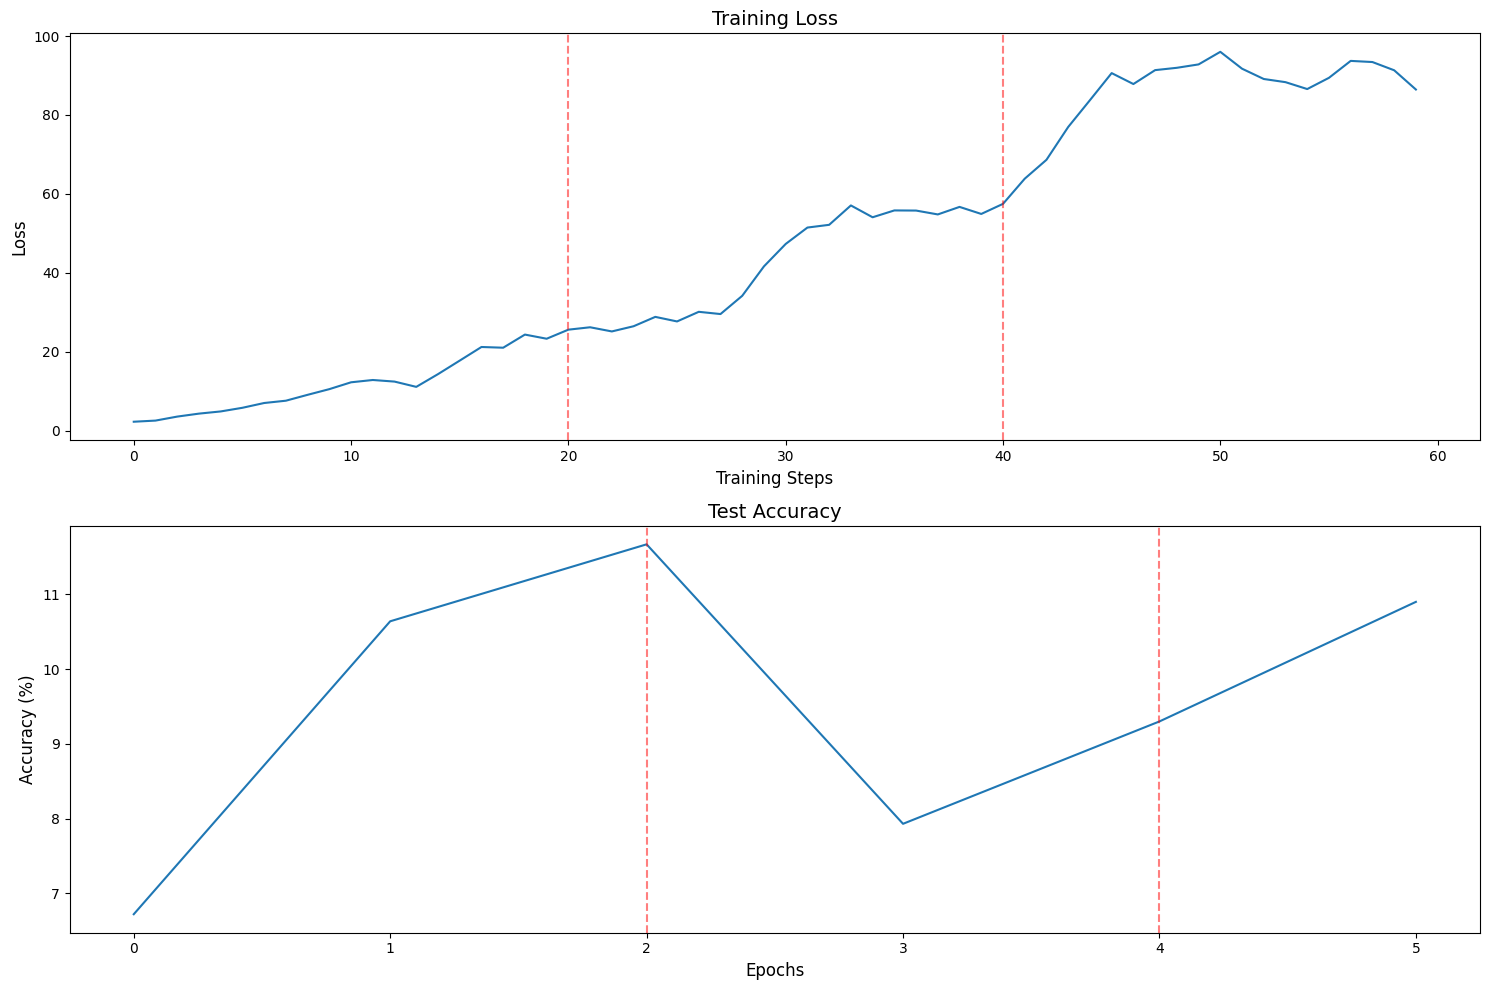

In [9]:
for model_name, train_log in train_logs.items():
    all_train_losses = train_log['all_train_losses']
    all_test_accuracies = train_log['all_test_accuracies']

    # Create separate figures for loss and accuracy
    # Loss figure
    fig_loss = plt.figure(figsize=(15, 5))
    combined_losses = [loss for run_losses in all_train_losses for loss in run_losses]
    plt.plot(combined_losses)
    plt.title('Training Loss', fontsize=14)
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    for i in range(1, num_shuffles):
        plt.axvline(x=i*len(combined_losses)//num_shuffles, color='red', linestyle='--', alpha=0.5)
    plt.savefig(f'mnist_reshuffle_{model_name}_loss.png')
    plt.close(fig_loss)

    # Accuracy figure
    fig_acc = plt.figure(figsize=(15, 5))
    combined_accuracies = [acc for run_accuracies in all_test_accuracies for acc in run_accuracies]
    plt.plot(combined_accuracies)
    plt.title('Test Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    for i in range(1, num_shuffles):
        plt.axvline(x=i*len(combined_accuracies)//num_shuffles, color='red', linestyle='--', alpha=0.5)
    plt.savefig(f'mnist_reshuffle_{model_name}_accuracy.png')
    plt.close(fig_acc)

    # If you also want to display them together
    fig_combined, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    ax1.plot(combined_losses)
    ax1.set_title('Training Loss', fontsize=14)
    ax1.set_xlabel('Training Steps', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    for i in range(1, num_shuffles):
        ax1.axvline(x=i*len(combined_losses)//num_shuffles, color='red', linestyle='--', alpha=0.5)

    ax2.plot(combined_accuracies)
    ax2.set_title('Test Accuracy', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    for i in range(1, num_shuffles):
        ax2.axvline(x=i*len(combined_accuracies)//num_shuffles, color='red', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig(f'output/mnist_reshuffle_{model_name}_combined.png')
    plt.show()

In [ ]:
for model_name, train_log in train_logs.items():
    all_train_losses = train_log['all_train_losses']
    all_test_accuracies = train_log['all_test_accuracies']

    # Create separate figures for loss and accuracy
    # Loss figure
    fig_loss = plt.figure(figsize=(15, 5))
    combined_losses = [loss for run_losses in all_train_losses for loss in run_losses]
    plt.plot(combined_losses)
    plt.title('Training Loss', fontsize=14)
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    for i in range(1, num_shuffles):
        plt.axvline(x=i*len(combined_losses)//num_shuffles, color='red', linestyle='--', alpha=0.5)
    plt.savefig(f'mnist_reshuffle_{model_name}_loss.png')
    plt.close(fig_loss)

    # Accuracy figure
    fig_acc = plt.figure(figsize=(15, 5))
    combined_accuracies = [acc for run_accuracies in all_test_accuracies for acc in run_accuracies]
    plt.plot(combined_accuracies)
    plt.title('Test Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    for i in range(1, num_shuffles):
        plt.axvline(x=i*len(combined_accuracies)//num_shuffles, color='red', linestyle='--', alpha=0.5)
    plt.savefig(f'mnist_reshuffle_{model_name}_accuracy.png')
    plt.close(fig_acc)

    # If you also want to display them together
    fig_combined, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    ax1.plot(combined_losses)
    ax1.set_title('Training Loss', fontsize=14)
    ax1.set_xlabel('Training Steps', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    for i in range(1, num_shuffles):
        ax1.axvline(x=i*len(combined_losses)//num_shuffles, color='red', linestyle='--', alpha=0.5)

    ax2.plot(combined_accuracies)
    ax2.set_title('Test Accuracy', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    for i in range(1, num_shuffles):
        ax2.axvline(x=i*len(combined_accuracies)//num_shuffles, color='red', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig(f'output/mnist_reshuffle_{model_name}_combined.png')
    plt.show()